# Fairness Metric Age Effect Differences
This demonstration downloads census data by race/ethnicity and age.  Then, using "older" and "younger" groups, shows metric differences between racial/ethnic groups due to age, even when the underlying process does not depend on race/ethnicity.

In [1]:
import pandas as pd
import numpy as np
import censusdata
import re
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d
from scipy.special import expit
import math
import os
import random
from scipy.stats import gaussian_kde
from textwrap import wrap

### Set local path for saving charts, etc.
Input your path here!

In [2]:
local_save_path = '/YOUR/PATH/HERE'
os.path.isdir(local_save_path)

True

## Census Data - Age by Race/Ethnicity
I will analyze age effects on fairness metrics using the US population distributions.

### Census metadata
Here, I get variable info for tables that I want to examine.  I am interested in reace/ethnicity by age information from the 2019 American Community Survey.  Information about tables I want to examine can be found here:
 - https://censusreporter.org/topics/age-sex/
 - https://censusreporter.org/topics/race-hispanic/

In this section, I get metadata about variables I want to examine, which are needed for count pulls.

In [3]:
# List the tables I want to pul. 
table_list = ['B01001B', 'B01001C', 'B01001D', 'B01001E', 'B01001F', 'B01001G', 'B01001H', 'B01001I']

In [4]:
# Get metadata about fields in all the tables I want to use
table_metdata_raw = pd.concat(map(lambda x: pd.DataFrame(censusdata.censustable('acs5', 2019, x)), 
                                        table_list), axis=1) \
    .transpose() \
    .reset_index() \
    .rename(columns={'index':'variable'})

In [5]:
# Parse concept - get race/ethnicity category
table_info_1_df= table_metdata_raw.copy()
table_info_1_df['race_eth'] = table_metdata_raw.concept.str.split('[()]',2, expand=True).iloc[:,1]

In [6]:
# Parse label - get sex, age strings
table_info_1_df['sex'] = table_info_1_df.label.str.split('[!!]', expand=True).iloc[:,4]
table_info_1_df['age_grp'] = table_info_1_df.label.str.split('[!!]', expand=True).iloc[:,6]

In [7]:
# Drop columns with missing sex, age groups
table_info_1_df.dropna(how='any', subset=['sex', 'age_grp'], inplace=True)

In [8]:
table_info_1_df.head()

,variable,label,concept,predicateType,race_eth,sex,age_grp
2,B01001B_003E,Estimate!!Total:!!Male:!!Under 5 years,SEX BY AGE (BLACK OR AFRICAN AMERICAN ALONE),int,BLACK OR AFRICAN AMERICAN ALONE,Male:,Under 5 years
3,B01001B_004E,Estimate!!Total:!!Male:!!5 to 9 years,SEX BY AGE (BLACK OR AFRICAN AMERICAN ALONE),int,BLACK OR AFRICAN AMERICAN ALONE,Male:,5 to 9 years
4,B01001B_005E,Estimate!!Total:!!Male:!!10 to 14 years,SEX BY AGE (BLACK OR AFRICAN AMERICAN ALONE),int,BLACK OR AFRICAN AMERICAN ALONE,Male:,10 to 14 years
5,B01001B_006E,Estimate!!Total:!!Male:!!15 to 17 years,SEX BY AGE (BLACK OR AFRICAN AMERICAN ALONE),int,BLACK OR AFRICAN AMERICAN ALONE,Male:,15 to 17 years
6,B01001B_007E,Estimate!!Total:!!Male:!!18 and 19 years,SEX BY AGE (BLACK OR AFRICAN AMERICAN ALONE),int,BLACK OR AFRICAN AMERICAN ALONE,Male:,18 and 19 years


### Census age group string parsing

In [9]:
# Handle the lowest age group
age_tbl_1 = table_info_1_df.age_grp.str.extract(r'Under (?P<age_max>[0-9]*) years').dropna().astype('int')
age_tbl_1['age_min'] = 0
age_tbl_1['age_max'] = age_tbl_1['age_max'] - 1

In [10]:
# Handle the highest age group
age_tbl_2 = table_info_1_df.age_grp.str.extract(r'(?P<age_min>[0-9]*) years and over').dropna().astype('int')
age_tbl_2['age_max'] = 99 # arbitray end point for plots

In [11]:
# Handle age ranges 
age_tbl_3 = table_info_1_df.age_grp.str.extract(r'(?P<age_min>[0-9]*) (?:to|and) (?P<age_max>[0-9]*) years').dropna().astype('int')
age_tbl_3

,age_min,age_max
3,5,9
4,10,14
5,15,17
6,18,19
7,20,24
...,...,...
242,35,44
243,45,54
244,55,64
245,65,74


In [12]:
# Handle 2 year ranges
age_tbl_4 = table_info_1_df.age_grp.str.extract(r'(?P<age_min>[0-9]*) and (?P<age_max>[0-9]*) years').dropna().astype('int')

In [13]:
# Combine the info
age_tbl_comb = age_tbl_3.combine_first(age_tbl_2).combine_first(age_tbl_1).astype('int')

In [14]:
table_info_2_df = table_info_1_df.join(age_tbl_comb, how='left')

### Census field conversions
Convert some fields to categorical, drop others

In [15]:
table_info_df = table_info_2_df.copy()[['variable', 'race_eth', 'sex', 'age_grp', 'age_min', 'age_max']]
table_info_df['race_eth'] = pd.Categorical(table_info_2_df.race_eth, categories=table_info_2_df.race_eth.unique())
table_info_df['age_grp'] = pd.Categorical(table_info_2_df.age_grp, categories=table_info_2_df.age_grp.unique())

In [16]:
table_info_df.head()

,variable,race_eth,sex,age_grp,age_min,age_max
2,B01001B_003E,BLACK OR AFRICAN AMERICAN ALONE,Male:,Under 5 years,0,4
3,B01001B_004E,BLACK OR AFRICAN AMERICAN ALONE,Male:,5 to 9 years,5,9
4,B01001B_005E,BLACK OR AFRICAN AMERICAN ALONE,Male:,10 to 14 years,10,14
5,B01001B_006E,BLACK OR AFRICAN AMERICAN ALONE,Male:,15 to 17 years,15,17
6,B01001B_007E,BLACK OR AFRICAN AMERICAN ALONE,Male:,18 and 19 years,18,19


### Census population counts by age with race/ethnicity
Here, I pull the variables identified above and aggregate to combine sex categories.

In [17]:
# Pull the entire US counts for all variables listed in table_info_df
census_counts_df = censusdata.download('acs5', 2019,
                             censusdata.censusgeo([('us','*')]),
                             table_info_df.variable.to_list())
census_counts_df.head()

,B01001B_003E,B01001B_004E,B01001B_005E,B01001B_006E,B01001B_007E,B01001B_008E,B01001B_009E,B01001B_010E,B01001B_011E,B01001B_012E,...,B01001I_022E,B01001I_023E,B01001I_024E,B01001I_025E,B01001I_026E,B01001I_027E,B01001I_028E,B01001I_029E,B01001I_030E,B01001I_031E
"United States: Summary level: 010, us:1",1390883,1432012,1485845,911088,644594,1662549,1678054,1406596,2520532,2476388,...,954620,2321468,2262448,2140552,4093134,3373036,2396670,1378777,695641,286388


In [18]:
# Convert to long format
census_long_df = census_counts_df.transpose().astype('int').reset_index()
census_long_df.columns= ['variable', 'count']
census_long_df.head()

,variable,count
0,B01001B_003E,1390883
1,B01001B_004E,1432012
2,B01001B_005E,1485845
3,B01001B_006E,911088
4,B01001B_007E,644594


In [19]:
# Join in metadata
census_long_df = census_long_df.merge(table_info_df[['variable', 'race_eth', 'sex', 'age_grp', 'age_min', 'age_max']], 
                                                    how='inner', on='variable')

In [20]:
# Aggregate to combine sex categories
census_long_comb_df = census_long_df.groupby(['race_eth', 'age_grp']) \
    .agg({'count':np.sum, 'age_min': 'first', 'age_max':'first'}) \
    .reset_index()
census_long_comb_df.head()

,race_eth,age_grp,count,age_min,age_max
0,BLACK OR AFRICAN AMERICAN ALONE,Under 5 years,2740124,0,4
1,BLACK OR AFRICAN AMERICAN ALONE,5 to 9 years,2828410,5,9
2,BLACK OR AFRICAN AMERICAN ALONE,10 to 14 years,2929886,10,14
3,BLACK OR AFRICAN AMERICAN ALONE,15 to 17 years,1786717,15,17
4,BLACK OR AFRICAN AMERICAN ALONE,18 and 19 years,1264392,18,19


In [21]:
census_long_comb_df['age_grp'].value_counts()

85 years and over    8
75 to 84 years       8
65 to 74 years       8
55 to 64 years       8
45 to 54 years       8
35 to 44 years       8
30 to 34 years       8
25 to 29 years       8
20 to 24 years       8
18 and 19 years      8
15 to 17 years       8
10 to 14 years       8
5 to 9 years         8
Under 5 years        8
Name: age_grp, dtype: int64

### Census age interpolation (approximate age distribution)
Here, I go from discrete age bins to a dataframe that has 1 row per race/ethnicity and age in years.  This is done via interpolation and so results in an approximate smoothed shape

In [22]:
# Apply the counts to the bin midpoint - scale to account for differing bin sizes
census_re_1 =  census_long_comb_df.copy()
census_re_1['age_mid'] = (census_re_1['age_max'] + census_re_1['age_max']) / 2
census_re_1['age_width'] = census_re_1['age_max'] - census_re_1['age_min'] + 1
census_re_1['count_scale'] = census_re_1['count'] / census_re_1['age_width']

In [23]:
# Write a function to interpolate to age level
def get_age_interp(data):
    xnew = np.linspace(np.min(data.age_min), np.max(data.age_max), 
            num = math.ceil(1 + np.max(data.age_max) - np.min(data.age_min)), endpoint=True)
    f_cubic = interp1d(data['age_mid'], data['count_scale'], kind='quadratic',
                  fill_value = 'extrapolate')
    return pd.DataFrame({'age_yr': xnew, 'count_interp':f_cubic(xnew)})

In [24]:
# Apply function to each race/ethnicity group
census_interpolated_dist = census_re_1.groupby('race_eth').apply(get_age_interp).reset_index()
census_interpolated_dist.drop(columns='level_1', errors='ignore', inplace=True)

In [25]:
# Get relative weights within groups
census_interpolated_dist['count_weight'] = census_interpolated_dist.groupby('race_eth')['count_interp'].transform(lambda x: x / np.sum(x))

#### Plot approximate age distributions by race/ethnicity

In [26]:
# Pivot to get groups in columns
pivot_dist = pd.pivot_table(census_interpolated_dist,
               index='age_yr', columns='race_eth', values='count_weight')
pivot_dist.head()

race_eth,BLACK OR AFRICAN AMERICAN ALONE,AMERICAN INDIAN AND ALASKA NATIVE ALONE,ASIAN ALONE,NATIVE HAWAIIAN AND OTHER PACIFIC ISLANDER ALONE,SOME OTHER RACE ALONE,TWO OR MORE RACES,"WHITE ALONE, NOT HISPANIC OR LATINO",HISPANIC OR LATINO
age_yr,,,,,,,,
0.0,0.012344,0.012374,0.008721,0.013460,0.014966,0.028183,0.009579,0.016932
1.0,0.012378,0.012553,0.008969,0.013334,0.014827,0.027751,0.009525,0.016706
2.0,0.012421,0.012734,0.009199,0.013225,0.014728,0.027317,0.009488,0.016520
3.0,0.012471,0.012916,0.009413,0.013131,0.014669,0.026882,0.009467,0.016375
4.0,0.012528,0.013099,0.009609,0.013054,0.014649,0.026446,0.009463,0.016271


In [27]:
# Plot grid info
num_plots = len(pivot_dist.columns)
num_rows = math.ceil(num_plots/2)

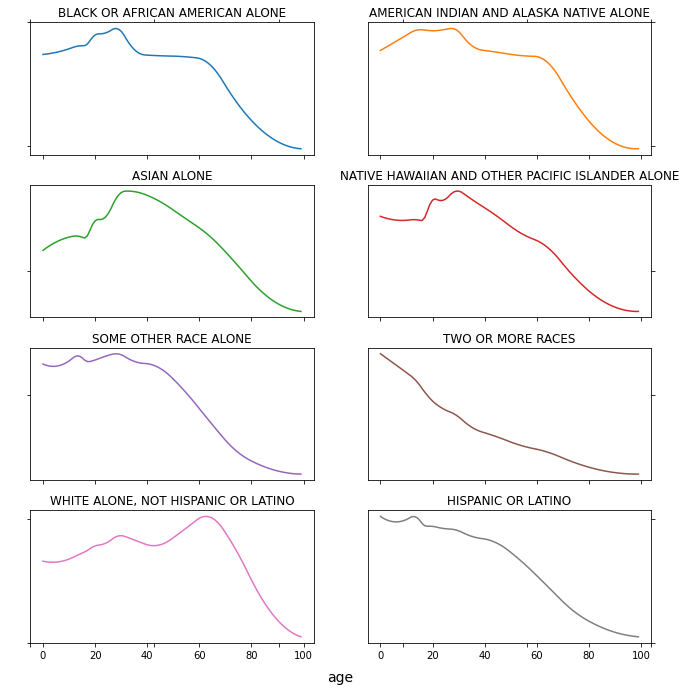

In [28]:
# Create the plots
fig, axes = plt.subplots(num_rows, 2, sharex=True, sharey=False, figsize=(10,10))
for i, ser_nm in enumerate(pivot_dist.columns):
    # Plot data, fit
    ax1 = axes[math.floor(i/2), i % 2]
    ax1.plot(pivot_dist.index, pivot_dist[ser_nm], color=sns.color_palette().as_hex()[i])
    ax1.title.set_text(ser_nm)
    ax1.get_yaxis().set_visible(False)
# Create a large frame to label x axis
ax = fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
ax.set_xlabel('age', labelpad=10, fontsize=14) 
plt.tight_layout()
plt.savefig(os.path.join(local_save_path, 'PLOT_age_dist_race_ethnicity.png'))
plt.show()

In [29]:
pivot_dist.head()

race_eth,BLACK OR AFRICAN AMERICAN ALONE,AMERICAN INDIAN AND ALASKA NATIVE ALONE,ASIAN ALONE,NATIVE HAWAIIAN AND OTHER PACIFIC ISLANDER ALONE,SOME OTHER RACE ALONE,TWO OR MORE RACES,"WHITE ALONE, NOT HISPANIC OR LATINO",HISPANIC OR LATINO
age_yr,,,,,,,,
0.0,0.012344,0.012374,0.008721,0.013460,0.014966,0.028183,0.009579,0.016932
1.0,0.012378,0.012553,0.008969,0.013334,0.014827,0.027751,0.009525,0.016706
2.0,0.012421,0.012734,0.009199,0.013225,0.014728,0.027317,0.009488,0.016520
3.0,0.012471,0.012916,0.009413,0.013131,0.014669,0.026882,0.009467,0.016375
4.0,0.012528,0.013099,0.009609,0.013054,0.014649,0.026446,0.009463,0.016271


In [30]:
# Plot only the 2 groups of interest
pivot_dist_lim = pivot_dist.drop(columns=['BLACK OR AFRICAN AMERICAN ALONE',
                                         'AMERICAN INDIAN AND ALASKA NATIVE ALONE',
                                         'ASIAN ALONE',
                                         'NATIVE HAWAIIAN AND OTHER PACIFIC ISLANDER ALONE',
                                         'SOME OTHER RACE ALONE', 'TWO OR MORE RACES'])

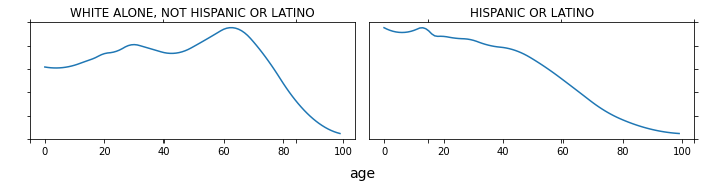

In [31]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(10, 3))
for i, ser_nm in enumerate(pivot_dist_lim.columns):
    # Plot data, fit
    ax1 = axes[i]
    ax1.plot(pivot_dist_lim.index, pivot_dist_lim[ser_nm])
    ax1.title.set_text(ser_nm)
    ax1.get_yaxis().set_visible(False)
# Create a large frame to label x axis
ax = fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
ax.set_xlabel('age', labelpad=10, fontsize=14) 
plt.tight_layout()
plt.savefig(os.path.join(local_save_path, 'PLOT_age_dist_race_ethnicity_lim.png'))
plt.show()

## Demonstration Data Preparation
Simulate process that is age-dependent but independent of race/ethnicity.  Use the age 18+ population.

- Draw 5,000 each random ages from 2 distributions (White Alone, not Hispanic or Latino and Hispanic or Latino)
- Calculate age-independent random feature "x", as well as noise/random feature "eta"
- Get target probability for each case - incorporate age, "x" and "eta"
- Get target status based on probability

### Draw 5,000 each random ages from 2 distributions (White Alone, not Hispanic or Latino and Hispanic or Latino)
I simulate a sample of individuals in two race/ethnicity groups.  I choose the oldest and one of the youngest race/ethnicity groups to show maximum effect of the age difference.  Restrict to the 18+ population.  

In [32]:
# Get age 18+ dists for the selected race/ethnicity groups
census_selected = census_interpolated_dist[census_interpolated_dist['race_eth'] \
                                           .isin(['WHITE ALONE, NOT HISPANIC OR LATINO',
                                                 'HISPANIC OR LATINO']) &
                                          (census_interpolated_dist['age_yr'] >=18)]

In [33]:
# Function to draw a random sample from the above distributions
def sample_age_weighted(data, n=1000,
                       weight_var='count_weight'):
    """ Draw sample from an age distribution given in data.
    Require the data have cases and weights with nonzero sum"""
    if (len(data) == 0) or np.sum(data[weight_var] == 0):
        return pd.DataFrame()
    else:
        return data.sample(n=n, weights=data[weight_var], replace=True)

In [34]:
pop_data = census_selected[['race_eth', 'age_yr', 'count_weight']].groupby('race_eth') \
    .apply(lambda x: sample_age_weighted(x, 5000)) \
    .drop(columns='count_weight') \
    .reset_index(drop=True)
pop_data.head()

,race_eth,age_yr
0,"WHITE ALONE, NOT HISPANIC OR LATINO",55.0
1,"WHITE ALONE, NOT HISPANIC OR LATINO",55.0
2,"WHITE ALONE, NOT HISPANIC OR LATINO",52.0
3,"WHITE ALONE, NOT HISPANIC OR LATINO",20.0
4,"WHITE ALONE, NOT HISPANIC OR LATINO",69.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f39bdcf26a0>,
      dtype=object)

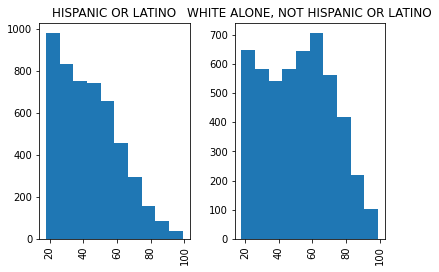

In [35]:
# Quick check of the age distributions
pop_data['age_yr'].hist(by=pop_data['race_eth'])

In [36]:
# Show overall mean age, group age
print(pop_data.agg({'age_yr':'mean'}))
pop_data.groupby('race_eth').agg({'age_yr':'mean'})

age_yr    47.7857
dtype: float64


,age_yr
race_eth,
HISPANIC OR LATINO,43.6982
"WHITE ALONE, NOT HISPANIC OR LATINO",51.8732


### Calculate age-independent random feature "x", as well as noise/random feature "eta"
I add an age-independent feature (x) as well as a noise feature to the data.  These are completely random

In [37]:
np.random.seed(1)

In [38]:
pop_data['x'] = np.random.normal(size = pop_data.shape[0])

In [39]:
pop_data['eta'] = np.random.normal(size = pop_data.shape[0])

In [40]:
pop_data.head()

,race_eth,age_yr,x,eta
0,"WHITE ALONE, NOT HISPANIC OR LATINO",55.0,1.624345,-0.122474
1,"WHITE ALONE, NOT HISPANIC OR LATINO",55.0,-0.611756,0.228170
2,"WHITE ALONE, NOT HISPANIC OR LATINO",52.0,-0.528172,-0.352305
3,"WHITE ALONE, NOT HISPANIC OR LATINO",20.0,-1.072969,-0.830553
4,"WHITE ALONE, NOT HISPANIC OR LATINO",69.0,0.865408,-0.261090


### Get target probability for each case - incorporate age, "x" and "eta"
"x" and "age" have roughly similar contributions, eta is much smaller.  I don't standardize the age feature.

In [41]:
# Function to get linear equation y = age + x + eta
def lineq(age, x, eta, coef_int = -6,
          coef_age = 1/10, coef_x = 1, coef_eta = 0.1):
    return (coef_int + coef_age * age + 
            coef_x * x  + 
            coef_eta * eta)

In [42]:
# Add the linear equation to the age
pop_data['sim_lin'] = pop_data.apply(lambda x: lineq(x.age_yr, x.x, x.eta), axis=1)

In [43]:
# Simulate the probability based on the linear equation
pop_data['sim_prob'] = pop_data['sim_lin'].apply(expit)

In [44]:
# Check probability averages, distributions

In [45]:
pop_data.agg({'sim_prob':'mean'})

sim_prob    0.329845
dtype: float64

In [46]:
pop_data.groupby('race_eth').agg({'sim_prob':'mean'})

,sim_prob
race_eth,
HISPANIC OR LATINO,0.266758
"WHITE ALONE, NOT HISPANIC OR LATINO",0.392932


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f39bd9be2b0>,
      dtype=object)

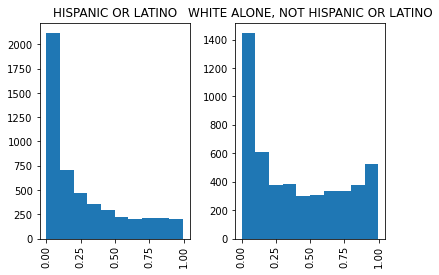

In [47]:
pop_data['sim_prob'].hist(by=pop_data['race_eth'])

### Get target status based on probability
Note that the rate of target status for white alone, not hispanic or latino is nearly double hispanic or latino, based on the strong age feature.

In [48]:
pop_data['targ_status'] = np.random.binomial(1, pop_data['sim_lin'].apply(expit), 
                                          size=pop_data.shape[0])

In [49]:
pop_data.groupby('race_eth').agg({'targ_status': 'mean'})

,targ_status
race_eth,
HISPANIC OR LATINO,0.2764
"WHITE ALONE, NOT HISPANIC OR LATINO",0.3880


## Logistic Regression Modeling
Use the data to get two logistic regression models:
- y = x + age
- y = x

For the first model, we should see fit coefficients similar to our inputs. 

For both, *show model probability distributions and 0.5 threshold*.

In [50]:
X_x_age = pop_data[['x', 'age_yr']]
X_x = pop_data[['x']]
y = pop_data['targ_status']

In [51]:
from sklearn.linear_model import LogisticRegression

In [52]:
# Fit 2 models
clf_x_age = LogisticRegression(random_state=0,  fit_intercept=True).fit(X_x_age, y)
clf_x = LogisticRegression(random_state=0,  fit_intercept=True).fit(X_x, y)

In [53]:
# Coefficients to data frame
coef_df = pd.DataFrame.from_dict({'model': ['x_age', 'x'],
                        'intercept': [clf_x_age.intercept_[0], clf_x.intercept_[0]],
                        'x': [clf_x_age.coef_[0,0], clf_x.coef_[0,0]],
                        'age': [clf_x_age.coef_[0,1], None]})
print(coef_df)

   model  intercept         x       age
0  x_age  -6.018028  1.064978  0.100525
1      x  -0.769743  0.651085       NaN


In [54]:
# Save the coefficients
coef_df.to_csv(os.path.join(local_save_path, 'DATA_regression_fit_coef.csv'), index=False)

In [55]:
# Generate predictions - probability and normal scales.  Save to a new data frame
prediction_df = pd.DataFrame.from_dict({'prob_x_age': clf_x_age.predict_proba(X_x_age)[:,1],
                                        'prob_x': clf_x.predict_proba(X_x)[:,1],
                                       'targ_x_age':clf_x_age.predict(X_x_age),
                                       'targ_x': clf_x.predict(X_x)})

In [56]:
# Concatenate data, predictions to simplify future steps
pop_pred_data = pd.concat([pop_data, prediction_df], axis=1)
pop_pred_data.head()

,race_eth,age_yr,x,eta,sim_lin,sim_prob,targ_status,prob_x_age,prob_x,targ_x_age,targ_x
0,"WHITE ALONE, NOT HISPANIC OR LATINO",55.0,1.624345,-0.122474,1.112098,0.752520,1,0.775692,0.571468,1,1
1,"WHITE ALONE, NOT HISPANIC OR LATINO",55.0,-0.611756,0.228170,-1.088939,0.251818,0,0.242198,0.237208,0,0
2,"WHITE ALONE, NOT HISPANIC OR LATINO",52.0,-0.528172,-0.352305,-1.363402,0.203688,0,0.205344,0.247195,0,0
3,"WHITE ALONE, NOT HISPANIC OR LATINO",20.0,-1.072969,-0.830553,-5.156024,0.005732,0,0.005765,0.187196,0,0
4,"WHITE ALONE, NOT HISPANIC OR LATINO",69.0,0.865408,-0.261090,1.739299,0.850598,1,0.862929,0.448610,1,0


In [57]:
# Show status boundaries - verify decision thresholds near 50%
print(pop_pred_data[['targ_x_age', 'prob_x_age']].groupby('targ_x_age').agg(['min', 'max']))
print(pop_pred_data[['targ_x', 'prob_x']].groupby('targ_x').agg(['min', 'max']))

           prob_x_age          
                  min       max
targ_x_age                     
0            0.000500  0.499857
1            0.500211  0.998124
          prob_x          
             min       max
targ_x                    
0       0.041076  0.499923
1       0.500050  0.864371


#### Confusion matrices

In [58]:
pd.crosstab(pop_pred_data['targ_status'], [pop_pred_data['race_eth'], pop_pred_data['targ_x_age']])

race_eth    HISPANIC OR LATINO      WHITE ALONE, NOT HISPANIC OR LATINO      
targ_x_age                   0    1                                   0     1
targ_status                                                                  
0                         3368  250                                2607   453
1                          563  819                                 500  1440

In [59]:
pd.crosstab(pop_pred_data['targ_status'], [pop_pred_data['race_eth'], pop_pred_data['targ_x']])

race_eth    HISPANIC OR LATINO      WHITE ALONE, NOT HISPANIC OR LATINO     
targ_x                       0    1                                   0    1
targ_status                                                                 
0                         3344  274                                2828  232
1                         1072  310                                1570  370

#### Model probability distributions by race/ethnicity

In [60]:
# Function to return KDE estimates
def kde_est_race_eth(X, selected_race_ethnicity, data, prob_col = 'prob_x_age'):
    """ Return the Gaussian kernel density estimates for probability distributions.
    Selects one race/ethnicity groups and then fits the KDE.  Returns a data frame
    containing the distribution.
    Returns a data frame containing both distributions.
        Input parameters:
            X: The x-values for the probability distribution.  Probably array of values in [0,1]
            selected_race_ethnicity: String containing the racial/ethnic group to analyze
            data: Data for the population of interest, with predictions (model inputs and outputs)
            prob_col: Name of the column containing the probabilty for which to generate a KDE """
    sel_pred = data[data['race_eth'] == selected_race_ethnicity]
    sel_gauss_kde = gaussian_kde(sel_pred[prob_col].astype('float'))
    score_dist = sel_gauss_kde(X)
    score_dist_df = pd.DataFrame.from_dict({'x': X,
                                            'race_eth': selected_race_ethnicity,
                                            'dist': score_dist})
    return score_dist_df

In [61]:
# Generate KDEs for both models
score_dist_x = np.linspace(0, 1, 200)
kde_x_age = pd.concat([kde_est_race_eth(score_dist_x, 'WHITE ALONE, NOT HISPANIC OR LATINO', pop_pred_data),
                          kde_est_race_eth(score_dist_x, 'HISPANIC OR LATINO', pop_pred_data)], axis=0) \
    .rename(columns = {'dist':'dist_x_age'})
kde_x = pd.concat([kde_est_race_eth(score_dist_x, 'WHITE ALONE, NOT HISPANIC OR LATINO', 
                                    pop_pred_data, 'prob_x'),
                          kde_est_race_eth(score_dist_x, 'HISPANIC OR LATINO', 
                                           pop_pred_data, 'prob_x')], axis=0) \
    .rename(columns = {'dist':'dist_x'})
kde_df = kde_x_age.merge(kde_x, on=['x', 'race_eth'])
kde_df.head()

,x,race_eth,dist_x_age,dist_x
0,0.000000,"WHITE ALONE, NOT HISPANIC OR LATINO",1.541730,0.002089
1,0.005025,"WHITE ALONE, NOT HISPANIC OR LATINO",1.614963,0.003562
2,0.010050,"WHITE ALONE, NOT HISPANIC OR LATINO",1.682944,0.005877
3,0.015075,"WHITE ALONE, NOT HISPANIC OR LATINO",1.744934,0.009395
4,0.020101,"WHITE ALONE, NOT HISPANIC OR LATINO",1.800295,0.014560


In [62]:
# Function to plot and save 
def dist_plot_save(data, value_col = 'dist_x_age',
                   plt_title = 'Logistic regression model for y=x=age',
                   x_label = 'model probability',
                   out_fn = None):
    """ Plots the KDE from one of the models.  Optionally saves the plot """
    maxv = np.max(data[value_col]) * 1.05
    pivot_data = data.pivot(index='x', columns='race_eth', values=value_col)
    labels = [ '\n'.join(wrap(l, 20)) for l in pivot_data.columns]
    
    plt.figure()
    pivot_data.plot()
    plt.vlines(0.5, 0, maxv, linestyles='dashed')
    plt.gca().set_ylim(0, maxv)
    plt.legend(title=None, framealpha=1, labels=labels,
              loc='upper right')
    plt.xlabel(x_label)
    plt.tick_params(axis='y', which='both', left=False, labelleft=False)
    plt.gca().xaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1))
    plt.ylabel('distribution')
    plt.title(plt_title)
    if (out_fn is not None):
        plt.savefig(out_fn, bbox_inches='tight')
    plt.show()

<Figure size 432x288 with 0 Axes>

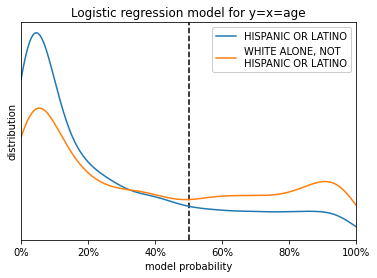

In [63]:
# Plot the x_age model distributions
dist_plot_save(kde_df, value_col = 'dist_x_age',
               plt_title = 'Logistic regression model for y=x=age',
               out_fn = os.path.join(local_save_path, 'PLOT_model_prob_dist_x_age.png'))

<Figure size 432x288 with 0 Axes>

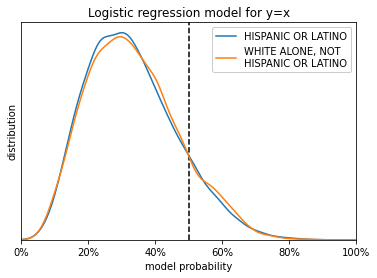

In [64]:
# Plot the x only distribution
dist_plot_save(kde_df, value_col = 'dist_x',
               plt_title = 'Logistic regression model for y=x',
               out_fn = os.path.join(local_save_path, 'PLOT_model_prob_dist_x.png'))

#### Plot the "actual" probability by race/ethinicity (input simulated probability)
This can be compared to the prob_x_age distribution

In [65]:
# Actual KDE alone
kde_actual_df = pd.concat([kde_est_race_eth(score_dist_x, 'WHITE ALONE, NOT HISPANIC OR LATINO', 
                                            pop_data, 'sim_prob'),
                          kde_est_race_eth(score_dist_x, 'HISPANIC OR LATINO', 
                                           pop_data, 'sim_prob')], axis=0)

<Figure size 432x288 with 0 Axes>

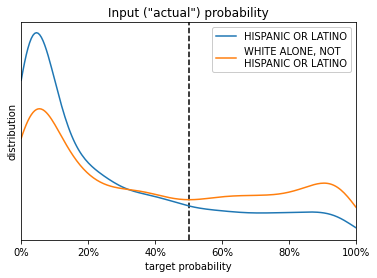

In [66]:
dist_plot_save(kde_actual_df, value_col = 'dist',
               plt_title = 'Input ("actual") probability',
               x_label = 'target probability')

# Fairness Metrics
I focus on just 3 metrics: False positives, false negatives, and accuracy.  I look at raw metrics, as well as metrics by age category

### Functions to calculate metrics

In [67]:
pop_pred_data.head()

,race_eth,age_yr,x,eta,sim_lin,sim_prob,targ_status,prob_x_age,prob_x,targ_x_age,targ_x
0,"WHITE ALONE, NOT HISPANIC OR LATINO",55.0,1.624345,-0.122474,1.112098,0.752520,1,0.775692,0.571468,1,1
1,"WHITE ALONE, NOT HISPANIC OR LATINO",55.0,-0.611756,0.228170,-1.088939,0.251818,0,0.242198,0.237208,0,0
2,"WHITE ALONE, NOT HISPANIC OR LATINO",52.0,-0.528172,-0.352305,-1.363402,0.203688,0,0.205344,0.247195,0,0
3,"WHITE ALONE, NOT HISPANIC OR LATINO",20.0,-1.072969,-0.830553,-5.156024,0.005732,0,0.005765,0.187196,0,0
4,"WHITE ALONE, NOT HISPANIC OR LATINO",69.0,0.865408,-0.261090,1.739299,0.850598,1,0.862929,0.448610,1,0


In [68]:
def metric_fp(data, model_target_col = 'targ_x_age'):
    """ Get false positive rate.  Use the model prediction in the indicated column.
    Inputs:
        data: Data for the population of interest, with predictions (model inputs and outputs)
        model_target_col: Name of the model prediction column"""
    sel_d = np.where(data['targ_status'] == 0, True, False)
    fp_ser = np.where(data[sel_d][model_target_col] == 1, 1, 0)
    try:
        fp_rate = np.mean(fp_ser)
    except:
        fp_rate = None
    return pd.DataFrame.from_dict({'fp_rate': [fp_rate]})

In [69]:
def metric_fn(data, model_target_col = 'targ_x_age'):
    """ Get false negative rate.  Use the model prediction in the indicated column.
    Inputs:
        data: Data for the population of interest, with predictions (model inputs and outputs)
        model_target_col: Name of the model prediction column"""
    sel_d = np.where(data['targ_status'] == 1, True, False)
    fn_ser = np.where(data[sel_d][model_target_col] == 0, 1, 0)
    try:
        fn_rate = np.mean(fn_ser)
    except:
        fn_rate = None
    return pd.DataFrame.from_dict({'fn_rate': [fn_rate]})

In [70]:
def metric_accuracy(data, model_target_col = 'targ_x_age'):
    """ Get accuracy.  Use the model prediction in the indicated column.
    Inputs:
        data: Data for the population of interest, with predictions (model inputs and outputs)
        model_target_col: Name of the model prediction column"""
    acc_ser = np.where(data['targ_status'] == data[model_target_col], 1, 0)
    try:
        accuracy = np.mean(acc_ser)
    except:
        accuracy = None
    return pd.DataFrame.from_dict({'accuracy': [accuracy]})

In [71]:
metric_fp(pop_pred_data)

,fp_rate
0,0.105271


In [72]:
pop_pred_data.groupby('race_eth').apply(lambda x: metric_fp(x)).reset_index(level=1, drop=True)

,fp_rate
race_eth,
HISPANIC OR LATINO,0.069099
"WHITE ALONE, NOT HISPANIC OR LATINO",0.148039


### Metrics by race/ethnicity group only

In [73]:
metrics_x_age = pd.concat([pop_pred_data.groupby('race_eth').apply(lambda x: metric_fp(x)),
                          pop_pred_data.groupby('race_eth').apply(lambda x: metric_fn(x)),
                          pop_pred_data.groupby('race_eth').apply(lambda x: metric_accuracy(x))], axis=1) \
    .reset_index(level=1, drop=True)
metrics_x_age['model'] = 'x_age'
metrics_x = pd.concat([pop_pred_data.groupby('race_eth').apply(lambda x: metric_fp(x, 'targ_x')),
                          pop_pred_data.groupby('race_eth').apply(lambda x: metric_fn(x, 'targ_x')),
                          pop_pred_data.groupby('race_eth').apply(lambda x: metric_accuracy(x, 'targ_x'))], axis=1) \
    .reset_index(level=1, drop=True)
metrics_x['model'] = 'x'

In [74]:
metrics_race_eth = pd.concat([metrics_x_age, metrics_x]).reset_index()
metrics_race_eth

,race_eth,fp_rate,fn_rate,accuracy,model
0,HISPANIC OR LATINO,0.069099,0.407381,0.8374,x_age
1,"WHITE ALONE, NOT HISPANIC OR LATINO",0.148039,0.257732,0.8094,x_age
2,HISPANIC OR LATINO,0.075732,0.775687,0.7308,x
3,"WHITE ALONE, NOT HISPANIC OR LATINO",0.075817,0.809278,0.6396,x


In [75]:
metrics_race_eth.to_csv(os.path.join(local_save_path, 'DATA_metrics_by_race_eth.csv'))

### Metrics by race/ethnicity plus age category
See if metrics "pass" when we add an age group.  Use large age buckets.

In [76]:
age_cond = [pop_pred_data.age_yr < 30,
           (pop_pred_data.age_yr >= 30) & (pop_pred_data.age_yr < 50),
           (pop_pred_data.age_yr >= 50) & (pop_pred_data.age_yr < 70),
            (pop_pred_data.age_yr >= 70) & (pop_pred_data.age_yr < 80),
           pop_pred_data.age_yr >= 80]
age_cond_lbl = ['18-29', '30-49', '50-69', '70-79', '80+']

In [77]:
age_cond = [pop_pred_data.age_yr < 40,
           (pop_pred_data.age_yr >= 40) & (pop_pred_data.age_yr < 70),
           pop_pred_data.age_yr >= 70]
age_cond_lbl = ['18-39', '40-69','70+']

In [78]:
pop_pred_data['age_category'] = np.select(age_cond, age_cond_lbl)

In [79]:
metrics_cat_x_age = pd.concat([pop_pred_data.groupby(['age_category', 'race_eth']).apply(lambda x: metric_fp(x)),
                          pop_pred_data.groupby(['age_category', 'race_eth']).apply(lambda x: metric_fn(x)),
                          pop_pred_data.groupby(['age_category', 'race_eth']).apply(lambda x: metric_accuracy(x))], axis=1) \
    .reset_index(level=2, drop=True)
metrics_cat_x_age['model'] = 'x_age'
metrics_cat_x = pd.concat([pop_pred_data.groupby(['age_category', 'race_eth']).apply(lambda x: metric_fp(x, 'targ_x')),
                          pop_pred_data.groupby(['age_category', 'race_eth']).apply(lambda x: metric_fn(x, 'targ_x')),
                          pop_pred_data.groupby(['age_category', 'race_eth']).apply(lambda x: metric_accuracy(x, 'targ_x'))], axis=1) \
    .reset_index(level=2, drop=True)
metrics_cat_x['model'] = 'x'

In [80]:
metrics_race_eth_cat = pd.concat([metrics_cat_x_age, metrics_cat_x]).reset_index()
metrics_race_eth_cat

,age_category,race_eth,fp_rate,fn_rate,accuracy,model
0,18-39,HISPANIC OR LATINO,0.002352,0.958333,0.937004,x_age
1,18-39,"WHITE ALONE, NOT HISPANIC OR LATINO",0.002053,0.952381,0.934227,x_age
2,40-69,HISPANIC OR LATINO,0.128278,0.471186,0.739547,x_age
3,40-69,"WHITE ALONE, NOT HISPANIC OR LATINO",0.202867,0.382716,0.723278,x_age
4,70+,HISPANIC OR LATINO,0.790123,0.022663,0.834101,x_age
5,70+,"WHITE ALONE, NOT HISPANIC OR LATINO",0.818627,0.032445,0.817245,x_age
6,18-39,HISPANIC OR LATINO,0.089370,0.520833,0.883260,x
7,18-39,"WHITE ALONE, NOT HISPANIC OR LATINO",0.102669,0.685714,0.858238,x
8,40-69,HISPANIC OR LATINO,0.058115,0.772881,0.666376,x
9,40-69,"WHITE ALONE, NOT HISPANIC OR LATINO",0.055197,0.799383,0.639206,x


In [81]:
metrics_race_eth_cat.to_csv(os.path.join(local_save_path, 'DATA_metrics_by_race_eth_age_category.csv'))

### Metrics by finer-grained age/race/ethnicity
Get within-5-year buckets, atarting at 18.  Set group to midpoint of bucket.

In [82]:
pop_pred_data['age_grp_5'] = 18 + 5 * np.floor((pop_pred_data['age_yr'] - 18)/5) + 2.5
pop_pred_data.tail()

,race_eth,age_yr,x,eta,sim_lin,sim_prob,targ_status,prob_x_age,prob_x,targ_x_age,targ_x,age_category,age_grp_5
9995,HISPANIC OR LATINO,30.0,0.072959,-0.943208,-3.021362,0.046470,0,0.050952,0.326900,0,0,18-39,30.5
9996,HISPANIC OR LATINO,50.0,0.489102,0.782216,-0.432676,0.393487,1,0.384404,0.389053,0,0,40-69,50.5
9997,HISPANIC OR LATINO,61.0,-1.014144,2.408434,-0.673300,0.337758,1,0.275669,0.193093,0,0,40-69,60.5
9998,HISPANIC OR LATINO,47.0,-0.062696,0.882786,-1.274418,0.218502,1,0.204220,0.307770,0,0,40-69,45.5
9999,HISPANIC OR LATINO,60.0,-1.437870,-0.099596,-1.447830,0.190336,0,0.179781,0.153694,0,0,40-69,60.5


In [83]:
metrics_grp5_x_age = pd.concat([pop_pred_data.groupby(['age_grp_5', 'race_eth']).apply(lambda x: metric_fp(x)),
                          pop_pred_data.groupby(['age_grp_5', 'race_eth']).apply(lambda x: metric_fn(x)),
                          pop_pred_data.groupby(['age_grp_5', 'race_eth']).apply(lambda x: metric_accuracy(x))], axis=1) \
    .reset_index(level=2, drop=True)
metrics_grp5_x_age['model'] = 'x_age'
metrics_grp5_x = pd.concat([pop_pred_data.groupby(['age_grp_5', 'race_eth']).apply(lambda x: metric_fp(x, 'targ_x')),
                          pop_pred_data.groupby(['age_grp_5', 'race_eth']).apply(lambda x: metric_fn(x, 'targ_x')),
                          pop_pred_data.groupby(['age_grp_5', 'race_eth']).apply(lambda x: metric_accuracy(x, 'targ_x'))], axis=1) \
    .reset_index(level=2, drop=True)
metrics_grp5_x['model'] = 'x'

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [84]:
metrics_race_eth_grp5 = pd.concat([metrics_grp5_x_age, metrics_grp5_x]).reset_index()
metrics_race_eth_grp5.head()

,age_grp_5,race_eth,fp_rate,fn_rate,accuracy,model
0,20.5,HISPANIC OR LATINO,0.000000,1.000000,0.961749,x_age
1,20.5,"WHITE ALONE, NOT HISPANIC OR LATINO",0.000000,1.000000,0.975000,x_age
2,25.5,HISPANIC OR LATINO,0.003817,1.000000,0.957798,x_age
3,25.5,"WHITE ALONE, NOT HISPANIC OR LATINO",0.000000,1.000000,0.947802,x_age
4,30.5,HISPANIC OR LATINO,0.001992,0.931034,0.947269,x_age


#### Plot metrics for the fine-grained age groups

In [85]:
# Function to plot and save 
def metric_plot_save(data, model_sel = 'x_age',
                     index_col = 'age_grp_5',
                     value_col = 'accuracy',
                     metric_name = None,
                     plt_title = 'Model y = x + age',
                     out_fn = None):
    """ Plots the metric vs. age group midpoint for one model """
    
    mdl_data = data[data['model'] == model_sel]
    maxv = np.max(mdl_data[value_col]) * 1.05
    minv = np.min(mdl_data[value_col]) * 0.9
    pivot_data = mdl_data.pivot(index=index_col, columns='race_eth', values=value_col)
    labels = [ '\n'.join(wrap(l, 20)) for l in pivot_data.columns]
    
    # Use metric name for title if unknown
    if (metric_name is not None):
        plt_suptitle = metric_name + ' vs. age group'
    else:
        plt_suptitle = value_col.capitalize() + ' vs. age group'
    
    plt.figure()
    pivot_data.plot()
    plt.gca().set_ylim(minv, maxv)
    plt.legend(title=None, framealpha=1, labels=labels)
    plt.xlabel('age group midpoint')
    #plt.tick_params(axis='y', which='both', left=False, labelleft=False)
    plt.gca().yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1))
    plt.ylabel(value_col)
    plt.suptitle(plt_suptitle)
    plt.title(plt_title)
    if (out_fn is not None):
        plt.savefig(out_fn, bbox_inches='tight')
    plt.show()

<Figure size 432x288 with 0 Axes>

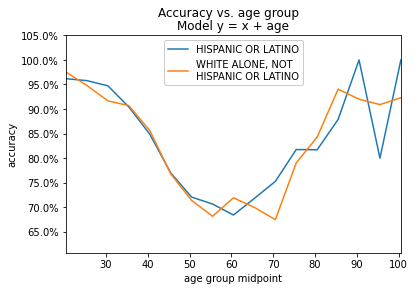

<Figure size 432x288 with 0 Axes>

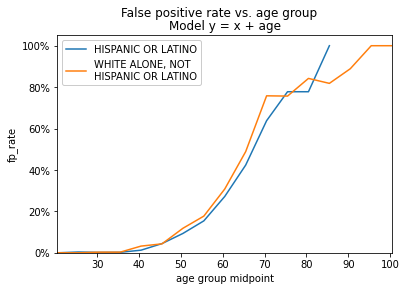

<Figure size 432x288 with 0 Axes>

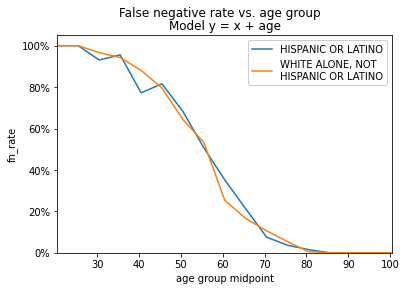

In [86]:
# Model y=x+age
metric_plot_save(metrics_race_eth_grp5, out_fn=os.path.join(local_save_path, 'PLOT_metric_age_grp_x_age_accuracy.png'))
metric_plot_save(metrics_race_eth_grp5, value_col='fp_rate', metric_name = 'False positive rate',
                 out_fn=os.path.join(local_save_path, 'PLOT_metric_age_grp_x_age_fp_rate.png'))
metric_plot_save(metrics_race_eth_grp5, value_col='fn_rate', metric_name = 'False negative rate',
                 out_fn=os.path.join(local_save_path, 'PLOT_metric_age_grp_x_age_fn_rate.png'))

<Figure size 432x288 with 0 Axes>

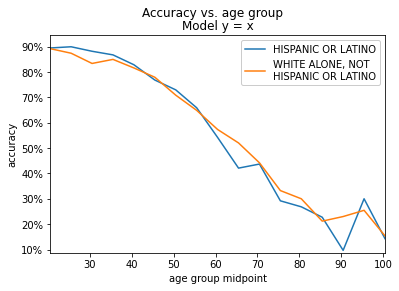

<Figure size 432x288 with 0 Axes>

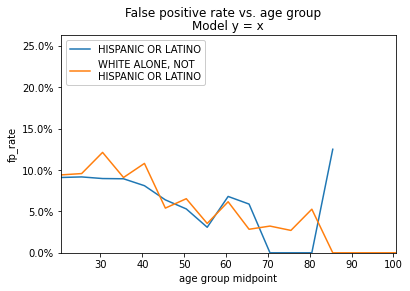

<Figure size 432x288 with 0 Axes>

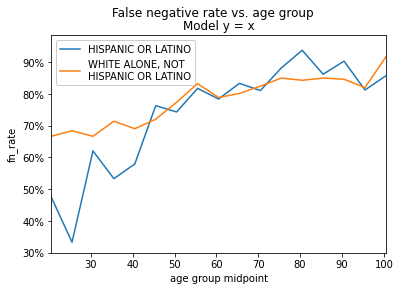

In [87]:
# Model y=x
metric_plot_save(metrics_race_eth_grp5, model_sel = 'x', plt_title='Model y = x',
                 out_fn=os.path.join(local_save_path, 'PLOT_metric_age_grp_x_accuracy.png'))
metric_plot_save(metrics_race_eth_grp5, model_sel = 'x', plt_title='Model y = x',
                 value_col='fp_rate', metric_name = 'False positive rate',
                 out_fn=os.path.join(local_save_path, 'PLOT_metric_age_grp_x_fp_rate.png'))
metric_plot_save(metrics_race_eth_grp5, model_sel = 'x', plt_title='Model y = x',
                 value_col='fn_rate', metric_name = 'False negative rate',
                 out_fn=os.path.join(local_save_path, 'PLOT_metric_age_grp_x_fn_rate.png'))

## Calibration
Show calibration curve across groups

In [88]:
pop_pred_data.head()

,race_eth,age_yr,x,eta,sim_lin,sim_prob,targ_status,prob_x_age,prob_x,targ_x_age,targ_x,age_category,age_grp_5
0,"WHITE ALONE, NOT HISPANIC OR LATINO",55.0,1.624345,-0.122474,1.112098,0.752520,1,0.775692,0.571468,1,1,40-69,55.5
1,"WHITE ALONE, NOT HISPANIC OR LATINO",55.0,-0.611756,0.228170,-1.088939,0.251818,0,0.242198,0.237208,0,0,40-69,55.5
2,"WHITE ALONE, NOT HISPANIC OR LATINO",52.0,-0.528172,-0.352305,-1.363402,0.203688,0,0.205344,0.247195,0,0,40-69,50.5
3,"WHITE ALONE, NOT HISPANIC OR LATINO",20.0,-1.072969,-0.830553,-5.156024,0.005732,0,0.005765,0.187196,0,0,18-39,20.5
4,"WHITE ALONE, NOT HISPANIC OR LATINO",69.0,0.865408,-0.261090,1.739299,0.850598,1,0.862929,0.448610,1,0,40-69,70.5


In [89]:
# Function to create 2 calibration plots
def calibration_decile_plot(data, 
                              model_prob = 'prob_x_age',
                              plt_title = 'Model y = x + age',
                              out_fn = None):
    """ Calibration by race/ethnicity """
    
    data['model_decile'] = pd.qcut(data[model_prob], q=10, labels=[str(x) for x in range(0,10)])
    data_agg = data.groupby(['model_decile', 'race_eth']).agg(model_prob = (model_prob, 'mean'),
                                                                actual_prob = ('targ_status', 'mean')) \
        .reset_index() 
    data_agg_pivot = data_agg.pivot(index='model_decile', columns='race_eth', values=['model_prob']) \
        .droplevel(axis=1, level=0)
    labels = [ '\n'.join(wrap(l, 20)) for l in data_agg_pivot.columns]
    plt.figure()
    data_agg_pivot.plot(style=['-','--'])
    plt.legend(title=None, framealpha=1, labels=labels)
    plt.xlabel('Model probability decile')
    plt.gca().yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1))
    plt.ylabel('Actual rate')
    plt.title(plt_title)
    if (out_fn is not None):
        plt.savefig(out_fn, bbox_inches='tight')
    plt.show()

<Figure size 432x288 with 0 Axes>

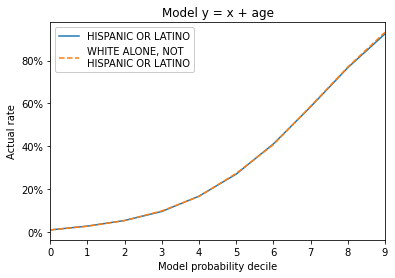

In [90]:
calibration_decile_plot(pop_pred_data, out_fn = os.path.join(local_save_path, 'PLOT_calibration_deciles_age_x.png'))

<Figure size 432x288 with 0 Axes>

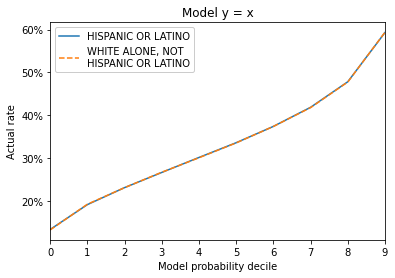

In [91]:
calibration_decile_plot(pop_pred_data, 'prob_x',
                         'Model y = x', out_fn = os.path.join(local_save_path, 'PLOT_calibration_deciles_x.png'))

#### Model probability vs. Actual probability (overall)

In [92]:
def calibration_prob_align_plot(data, 
                              model_prob = 'prob_x_age',
                              plt_title = 'Model y = x + age',
                              out_fn = None):
    """ Model probability vs. actual probability by race/ethnicity.  Uses
    deciles to calculate model probabilities"""
    
    data['model_grp_decile'] = data.groupby('race_eth')[model_prob].transform(lambda x: pd.qcut(x, q=10, labels=[str(x) for x in range(0,10)]))

    data_agg = data.groupby(['model_grp_decile', 'race_eth']).agg(model_prob = (model_prob, 'mean'),
                                                                actual_prob = ('targ_status', 'mean')) \
        .reset_index() 
    labels = [ '\n'.join(wrap(l, 20)) for l in data_agg['race_eth'].unique()]
    
    plt.figure()
    fig, ax = plt.subplots()
    data_agg.groupby('race_eth').plot(x='model_prob', y='actual_prob', ax=ax)
    plt.legend(title=None, framealpha=1, labels=labels)
    plt.xlabel('Model probability')
    plt.gca().yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1))
    plt.gca().xaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1))
    plt.ylabel('Actual rate')
    plt.title(plt_title)
    if (out_fn is not None):
        plt.savefig(out_fn, bbox_inches='tight')
    plt.show()

<Figure size 432x288 with 0 Axes>

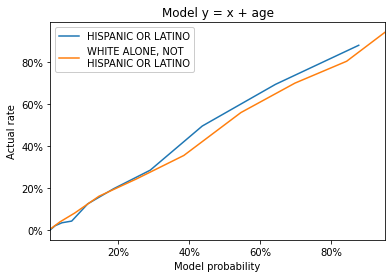

In [93]:
calibration_prob_align_plot(pop_pred_data, out_fn = os.path.join(local_save_path, 'PLOT_calibration_probs_age_x.png'))

<Figure size 432x288 with 0 Axes>

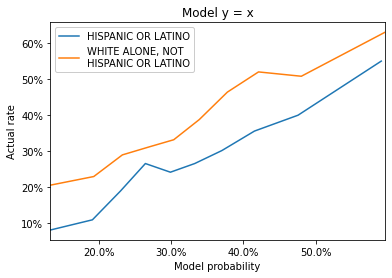

In [94]:
calibration_prob_align_plot(pop_pred_data, 'prob_x',
                            'Model y = x', out_fn= os.path.join(local_save_path, 'PLOT_calibration_probs_x.png'))

## Conclusions
- For processes that depend on age but not race/ethnicity, fairness metrics differ across racial/ethnic groups if age distributions vary.
- Differences disappear when we examine fine-grained age categories.
- Larger age buckets (10+ years) reduce but do not eliminate differences 